In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table
from itertools import combinations
from astropy.coordinates import SkyCoord
from astropy import units as u


save = True

sns.set(style="whitegrid")

## Orbits from elements

In [7]:
# data
path = 'results/My_results/'
file_name = 'orbital_elements_noRV.csv'
orbital_data = pd.read_csv(path+file_name)

# Binary
binary1 = pd.read_csv(path+'binaries_members_1_MCM.csv')
binary2 = pd.read_csv(path+'binaries_members_2_MCM.csv')

In [8]:
import matplotlib.pyplot as plt


def simulate_orbit_3d(elements, num_points=1000):
    a = elements['semi_major_axis_pc']
    e = elements['eccentricity']
    i = np.radians(elements['inclination_deg'])
    Omega = np.radians(elements['longitude_of_ascending_node_deg'])
    omega = np.radians(elements['argument_of_periapsis_deg'])

    # Parametrize orbit in perifocal frame (true anomaly)
    theta = np.linspace(0, 2 * np.pi, num_points)
    r = a * (1 - e**2) / (1 + e * np.cos(theta))

    # Perifocal coordinates
    x_pf = r * np.cos(theta)
    y_pf = r * np.sin(theta)
    z_pf = np.zeros_like(x_pf)

    # Rotation matrix from perifocal to ICRS
    R = np.array([
        [np.cos(Omega) * np.cos(omega) - np.sin(Omega) * np.sin(omega) * np.cos(i),
         -np.cos(Omega) * np.sin(omega) - np.sin(Omega) * np.cos(omega) * np.cos(i),
         np.sin(Omega) * np.sin(i)],
        [np.sin(Omega) * np.cos(omega) + np.cos(Omega) * np.sin(omega) * np.cos(i),
         -np.sin(Omega) * np.sin(omega) + np.cos(Omega) * np.cos(omega) * np.cos(i),
         -np.cos(Omega) * np.sin(i)],
        [np.sin(omega) * np.sin(i),
         np.cos(omega) * np.sin(i),
         np.cos(i)]
    ])

    coords_pf = np.vstack((x_pf, y_pf, z_pf))
    coords_3d = R @ coords_pf

    # Convert from parsec to AU:
    coords_3d *= u.pc.to(u.au)
    
    return coords_3d


# Selecting only the possible orbits elements:
orbital_data_selection = orbital_data[orbital_data['semi_major_axis_pc'] > 0]
orbital_data_selection.head()

,semi_major_axis_pc,eccentricity,inclination_deg,longitude_of_ascending_node_deg,argument_of_periapsis_deg,true_anomaly_deg,orbital_period_yr
2,0.002346,0.998959,66.467076,146.562339,166.124341,179.336962,0.003897
4,0.184017,0.974177,113.820132,326.630593,134.738349,110.671047,3.898218
5,0.006852,0.810554,65.488521,146.508493,205.624922,187.035536,0.027091
6,0.027369,0.812862,113.981681,326.004701,242.587365,248.666832,0.429057
7,0.015836,0.289480,66.012843,146.160646,45.222716,19.097034,0.143083


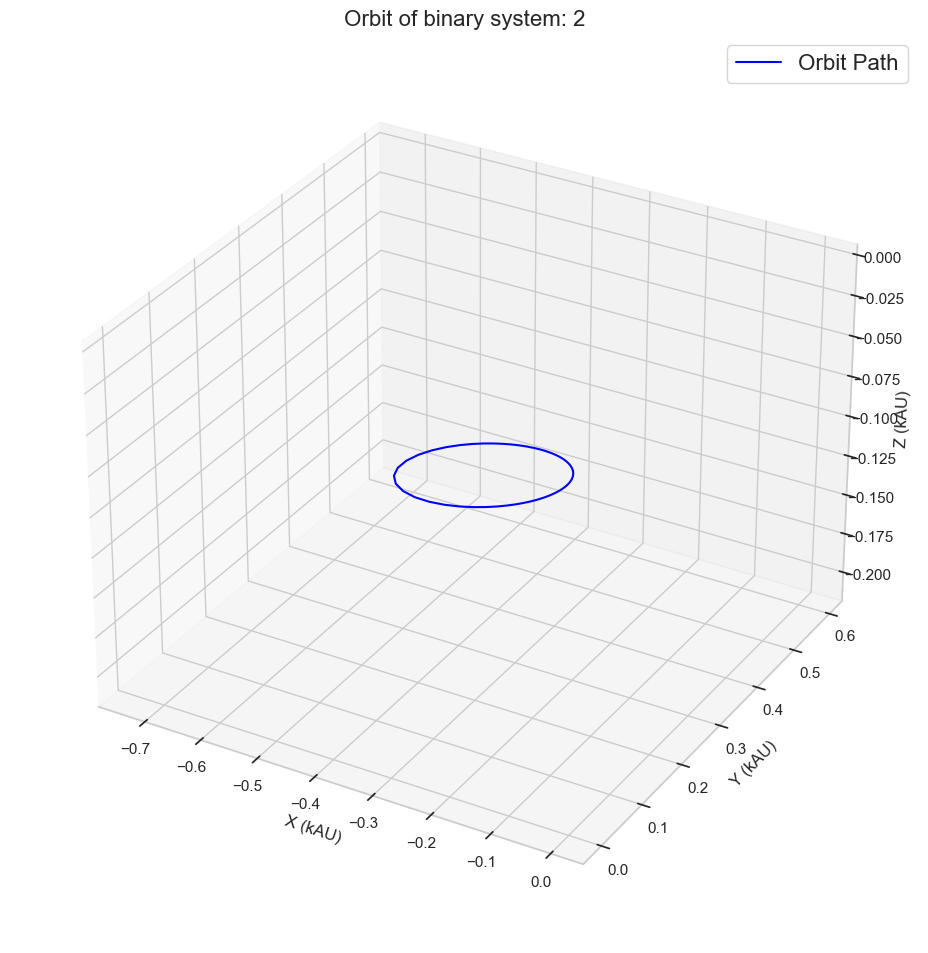

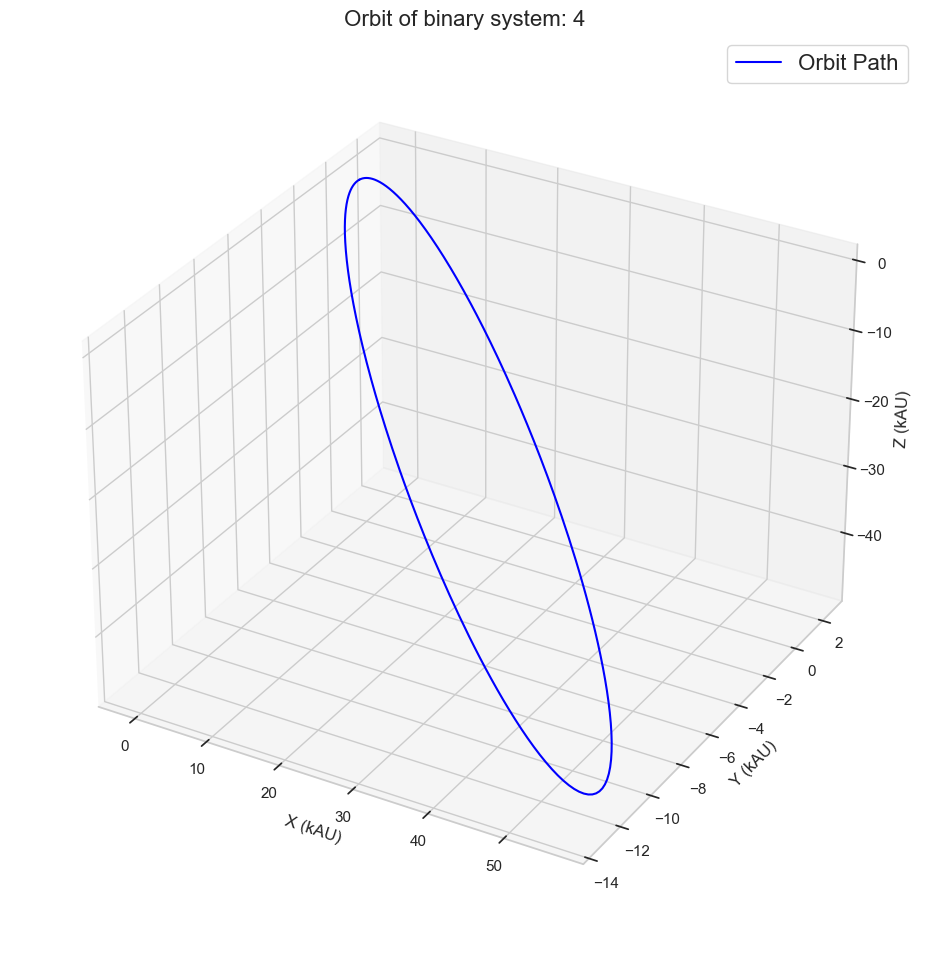

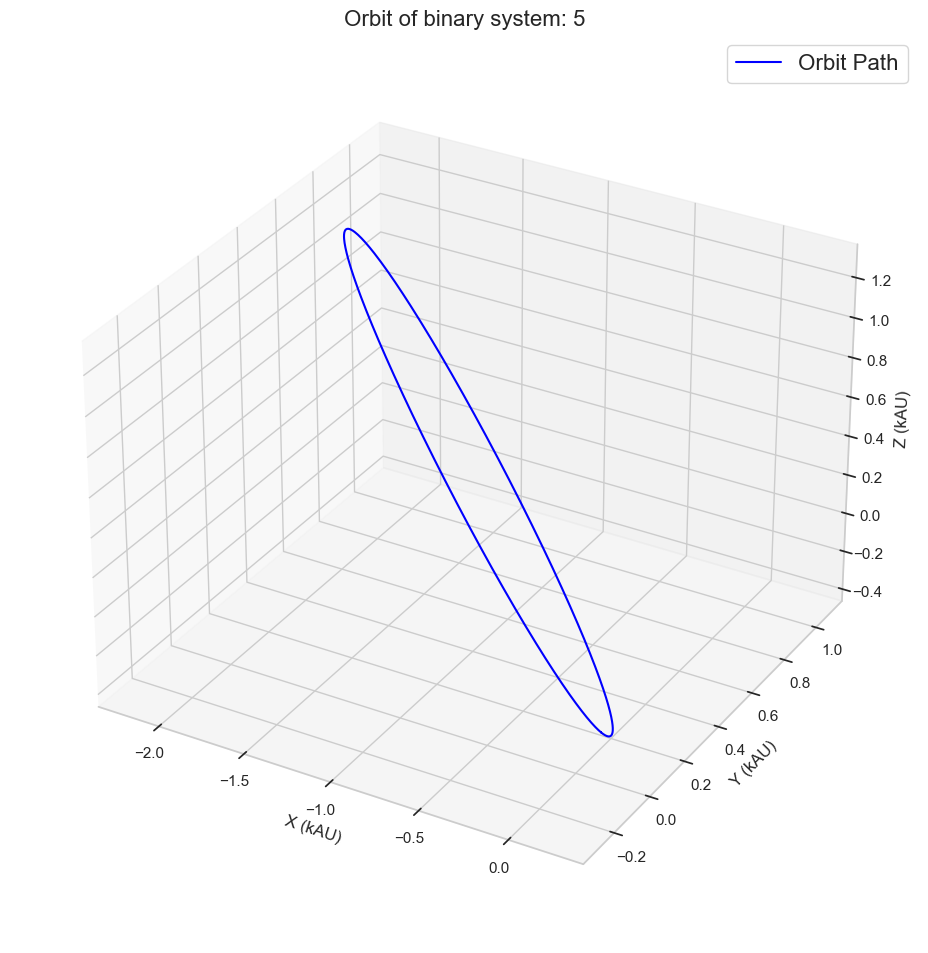

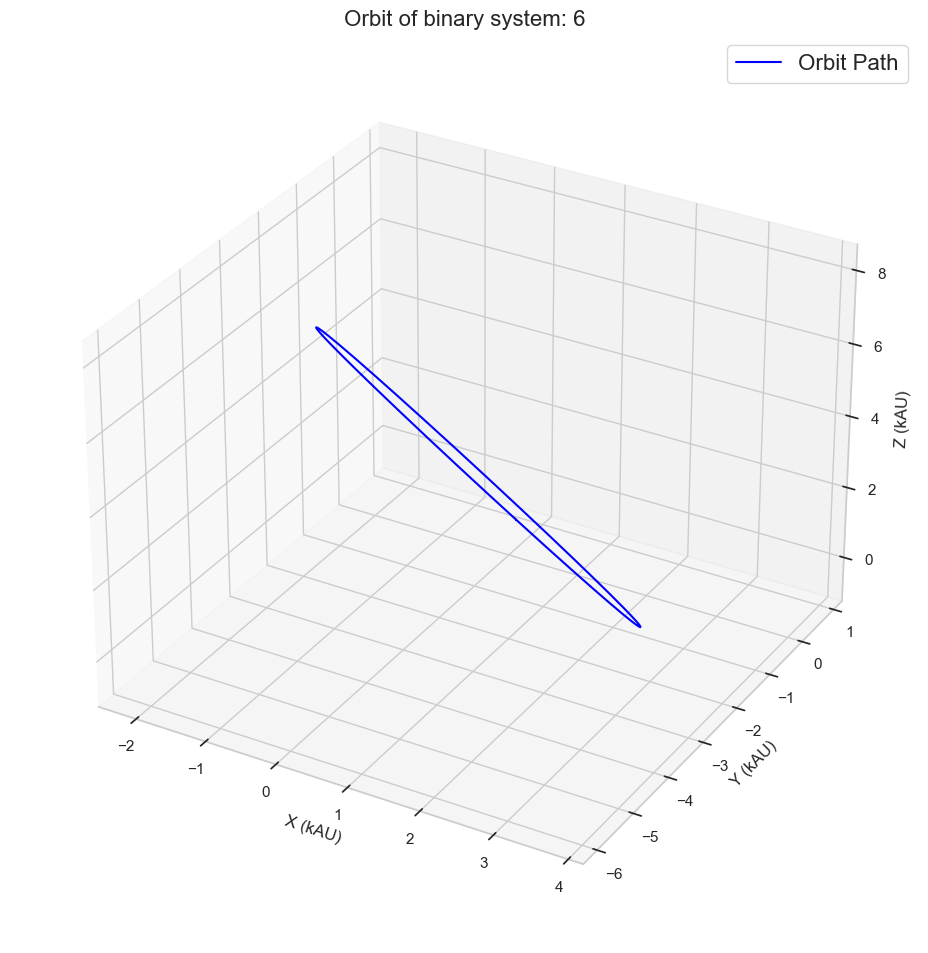

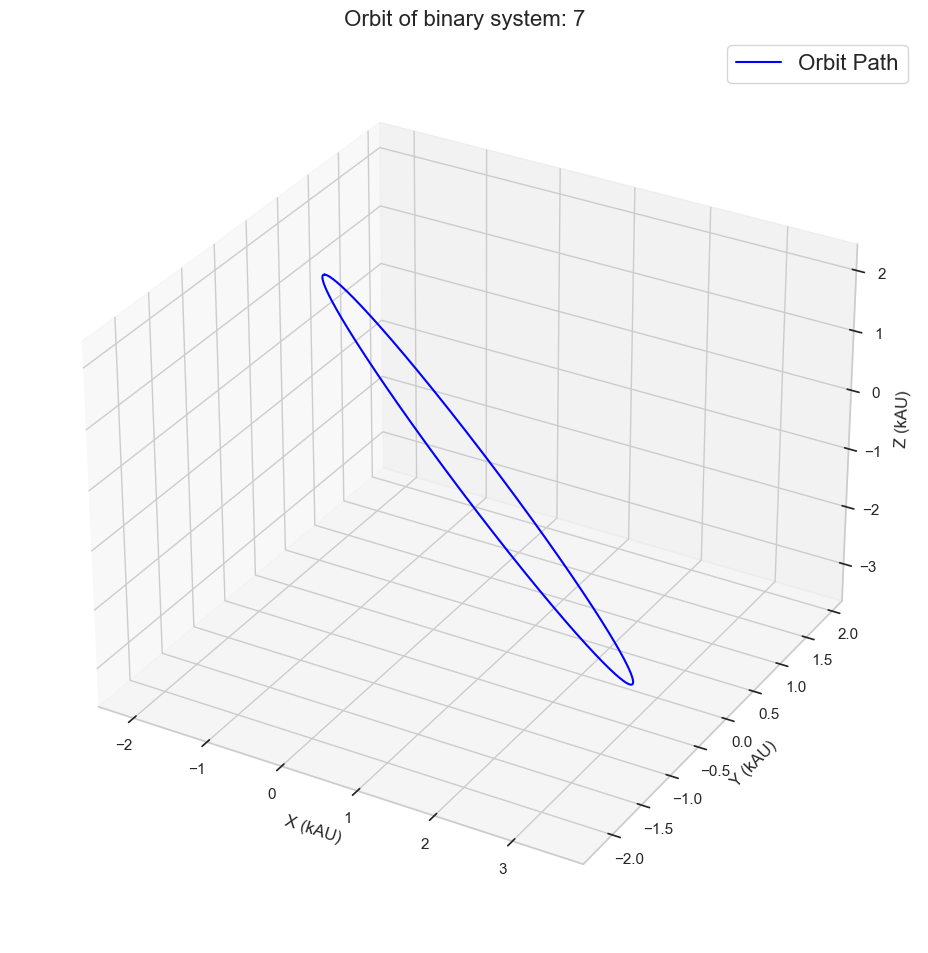

In [9]:
plotPath = path + 'orbital_plots_noRV/'
if not os.path.exists(plotPath):
    os.makedirs(plotPath)

for index, row in orbital_data_selection.iterrows():
    # Simulate the orbit
    coords_3d = simulate_orbit_3d(row)

    coords_3d = coords_3d / 1000

    # Plotting the orbit
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords_3d[0], coords_3d[1], coords_3d[2], label='Orbit Path', color='blue')

    # Set labels and title
    ax.set_xlabel('X (kAU)')
    ax.set_ylabel('Y (kAU)')
    ax.set_zlabel('Z (kAU)')
    ax.set_title(f'Orbit of binary system: {index}', fontsize=16)
    ax.legend(fontsize=16)
    ax.grid(True)
    ax.set_box_aspect(None, zoom=0.95)

    fig.tight_layout(pad=2.0)  # Increase padding
    #fig.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)
    

    if save:
        plt.savefig(plotPath+f'orbital_plot_{index}.png', dpi=300, bbox_inches='tight')
    
    plt.show()

## computational orbits

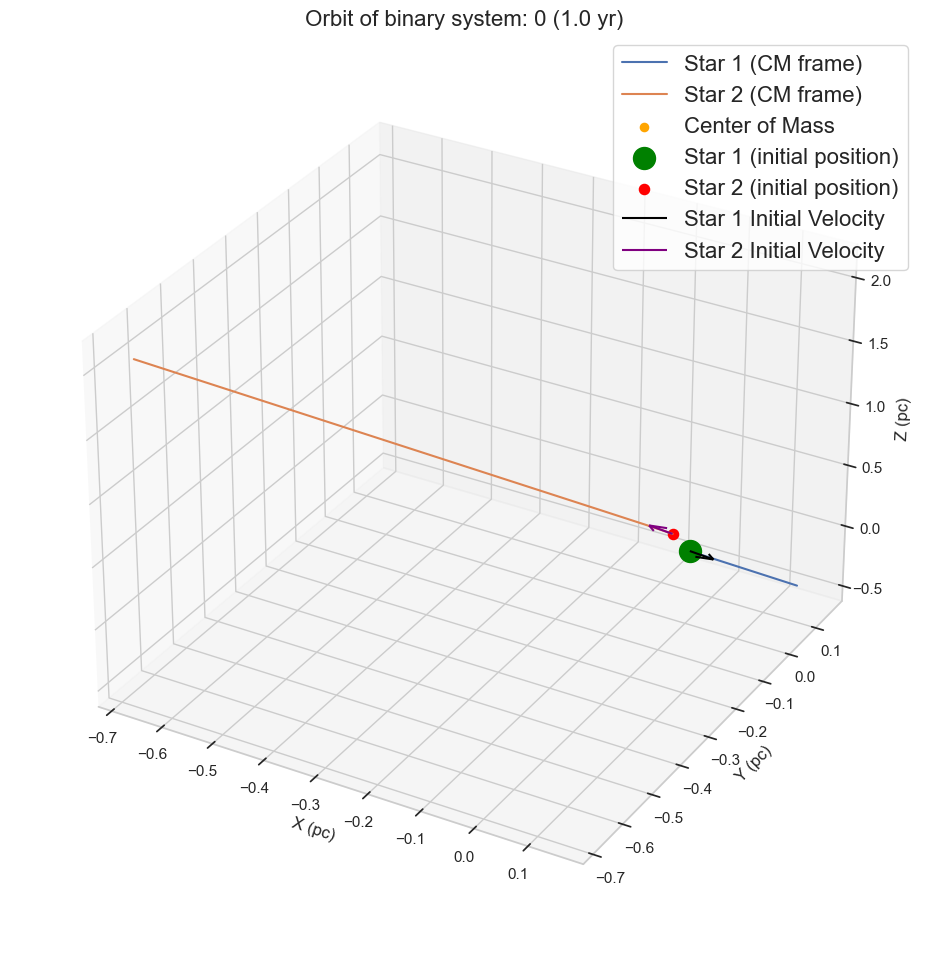

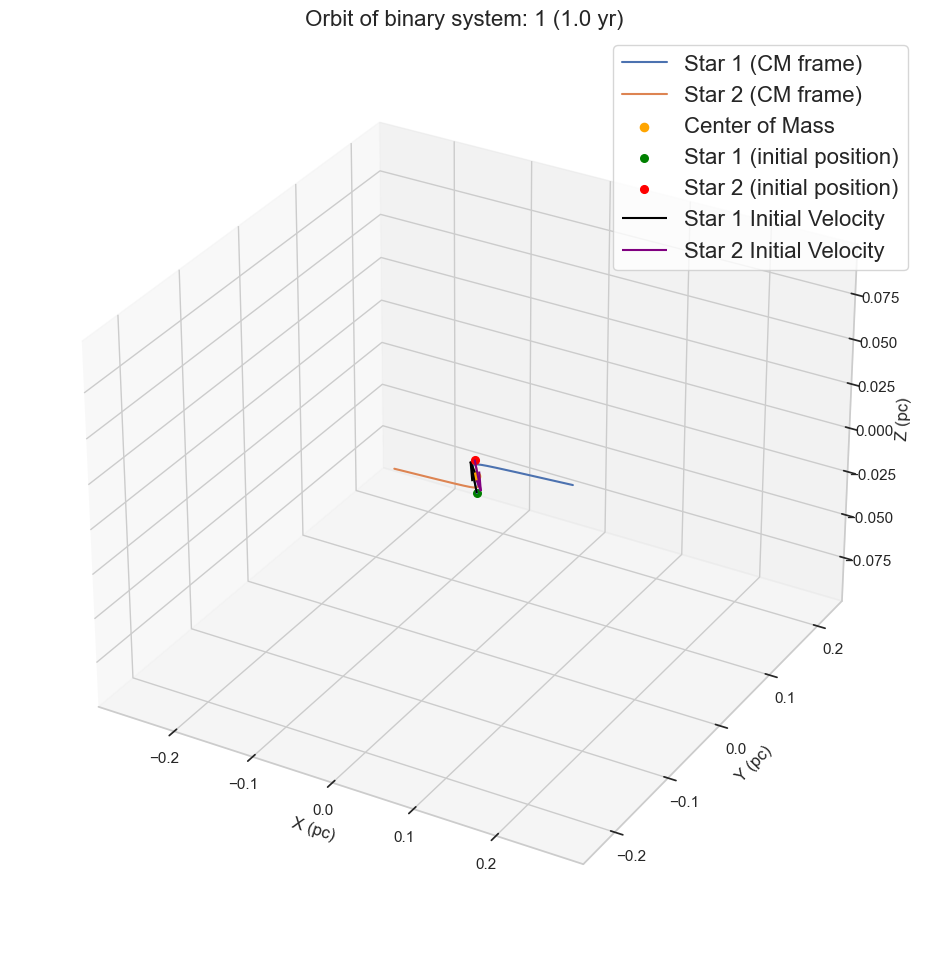

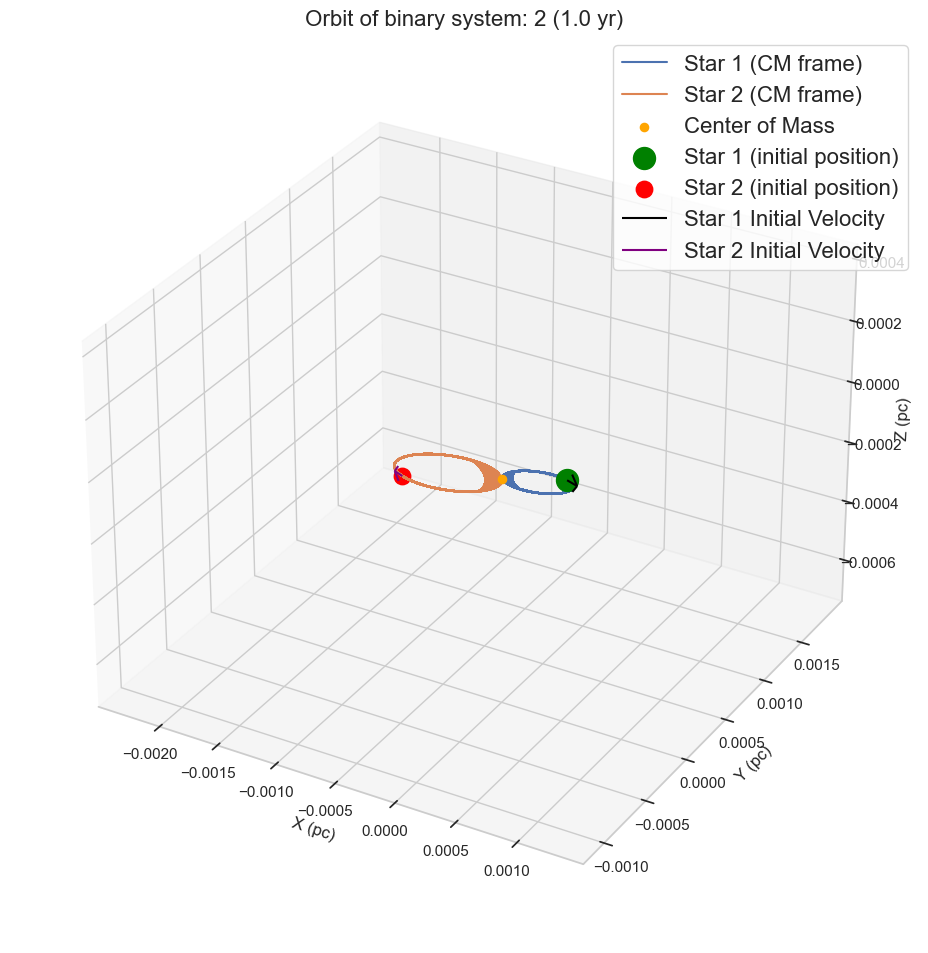

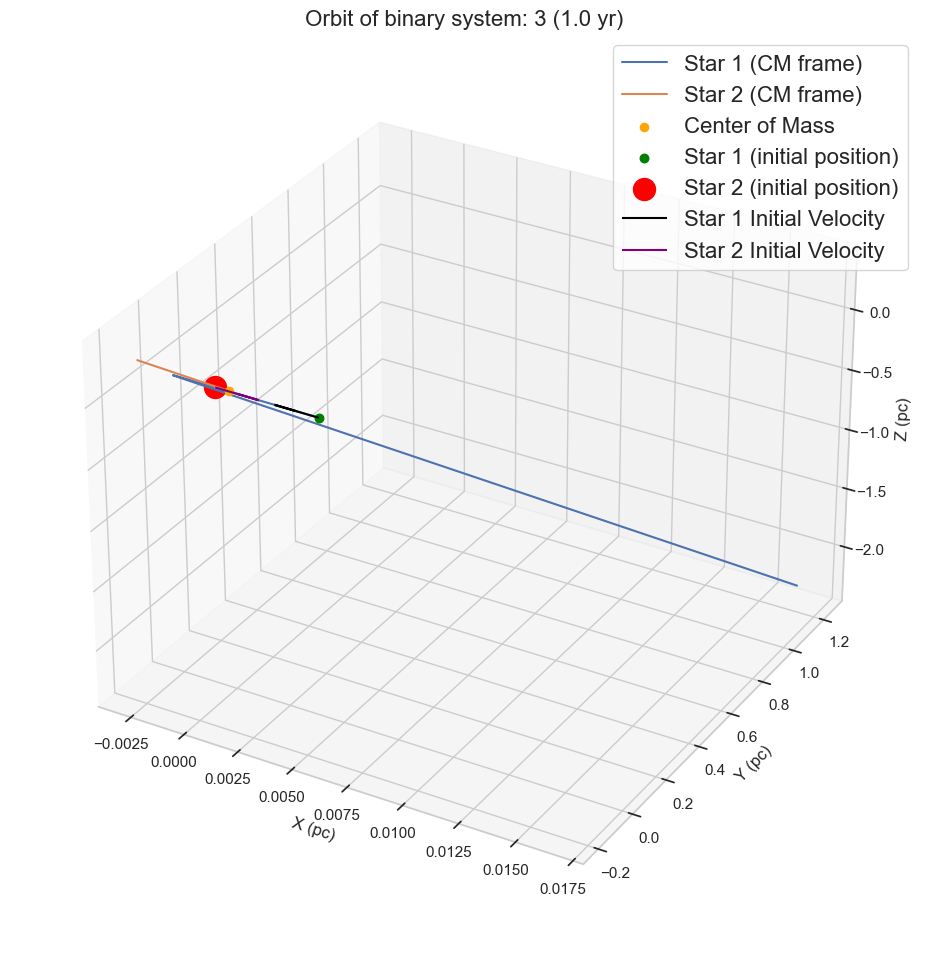

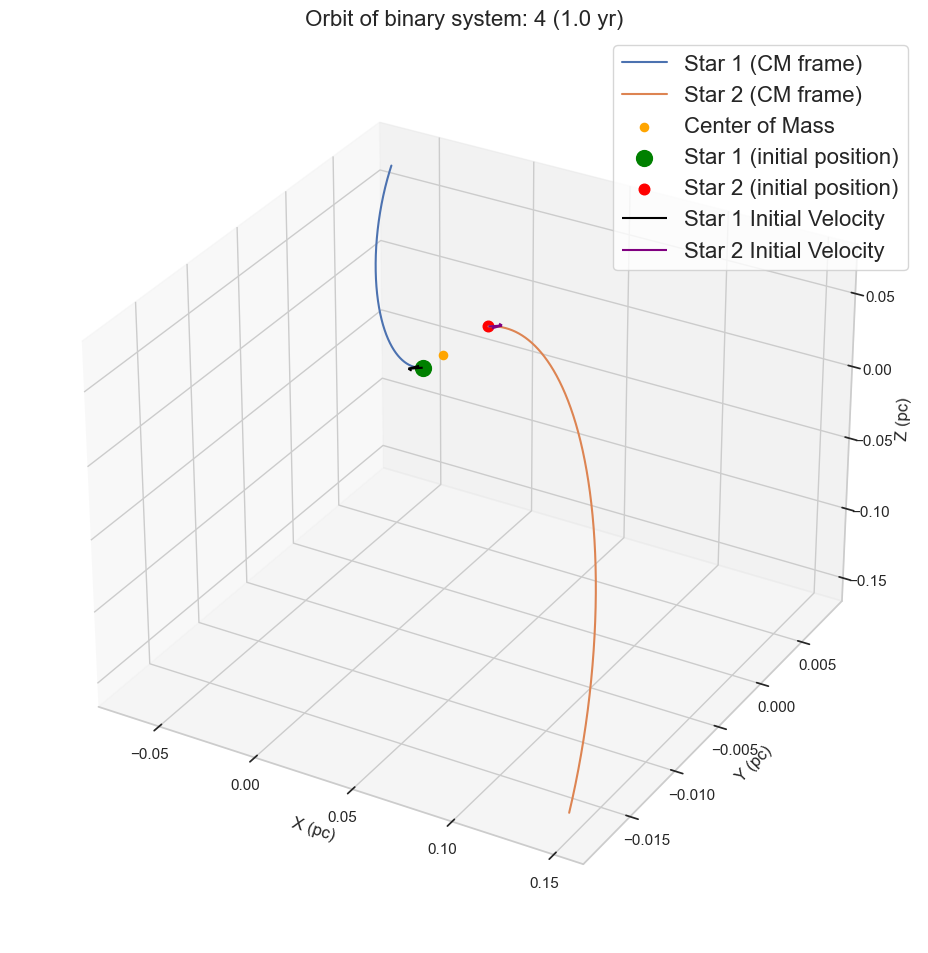

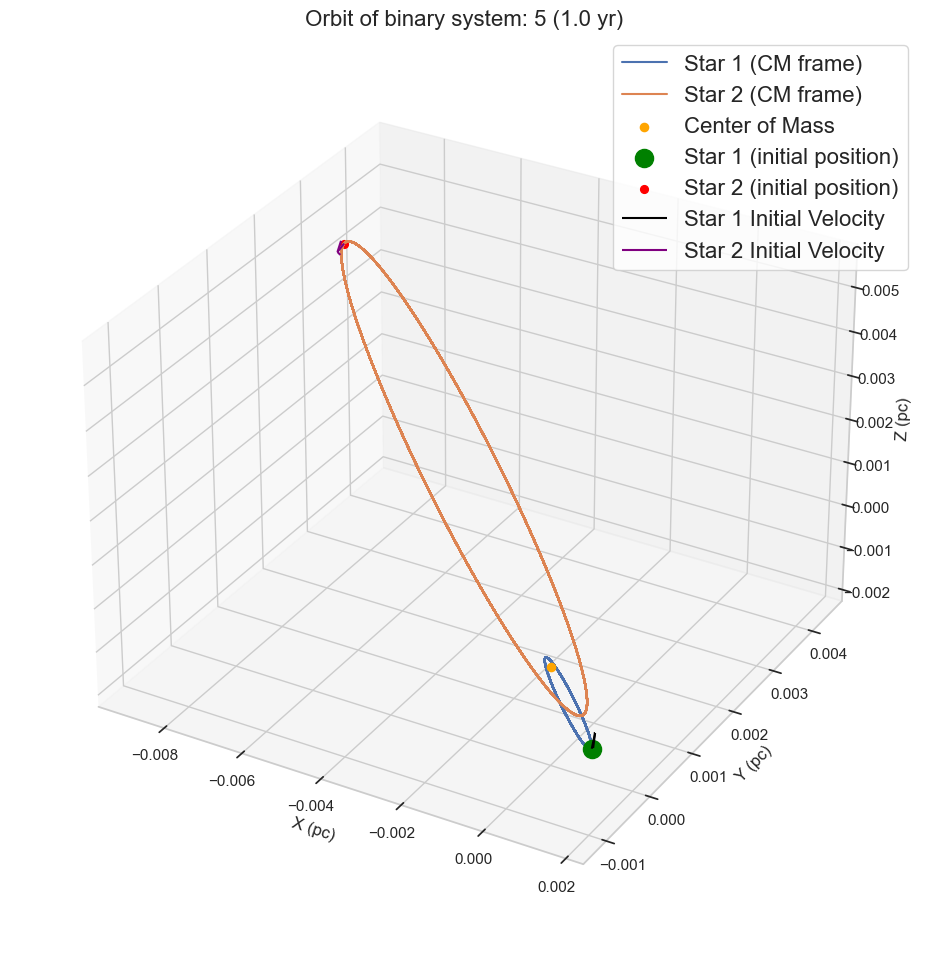

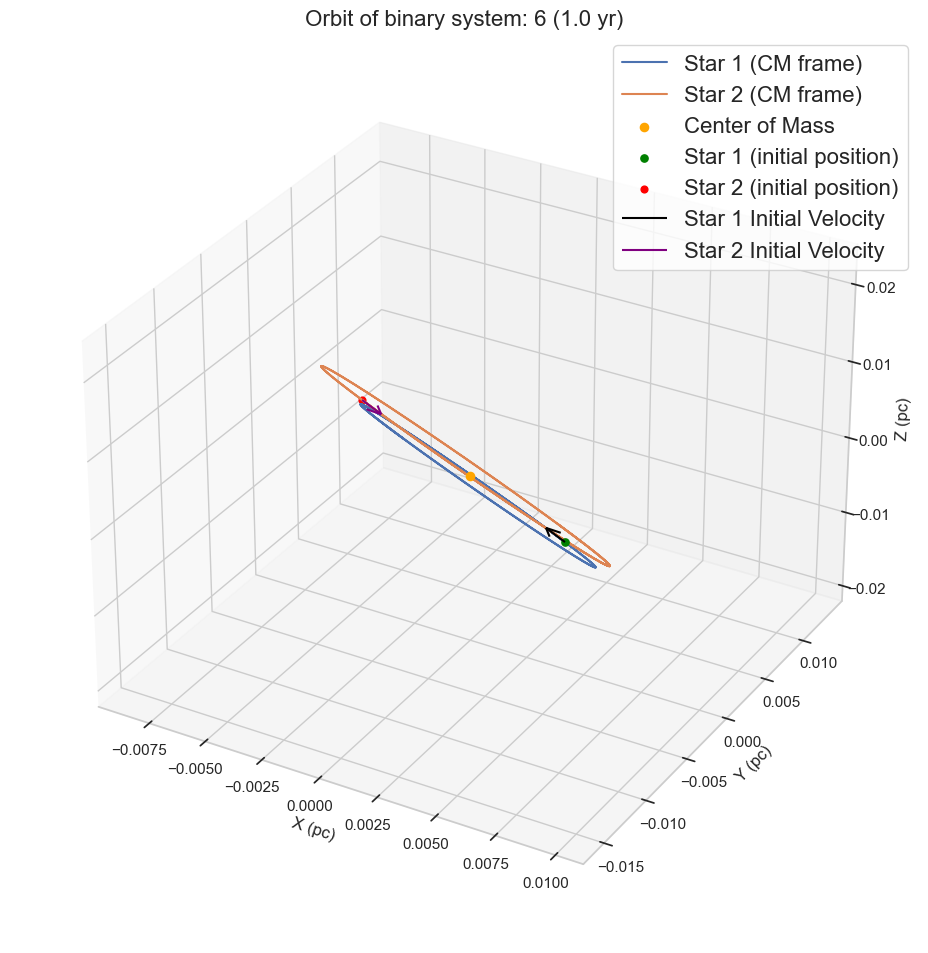

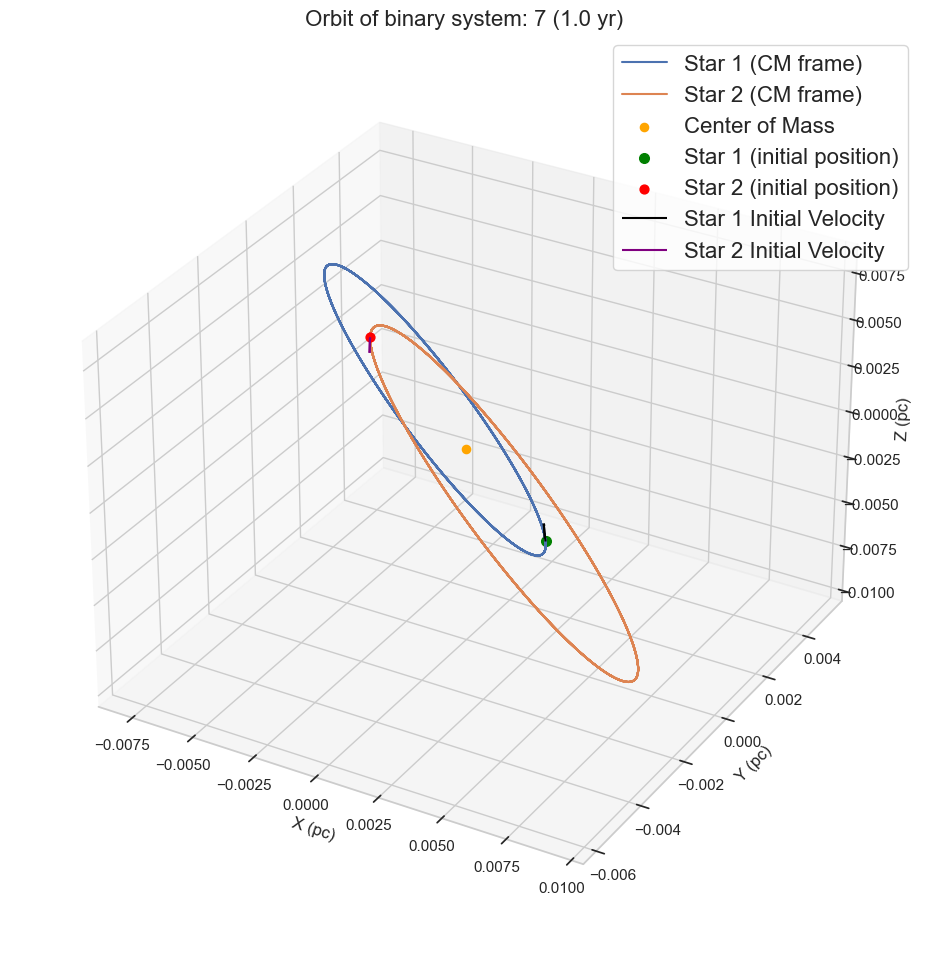

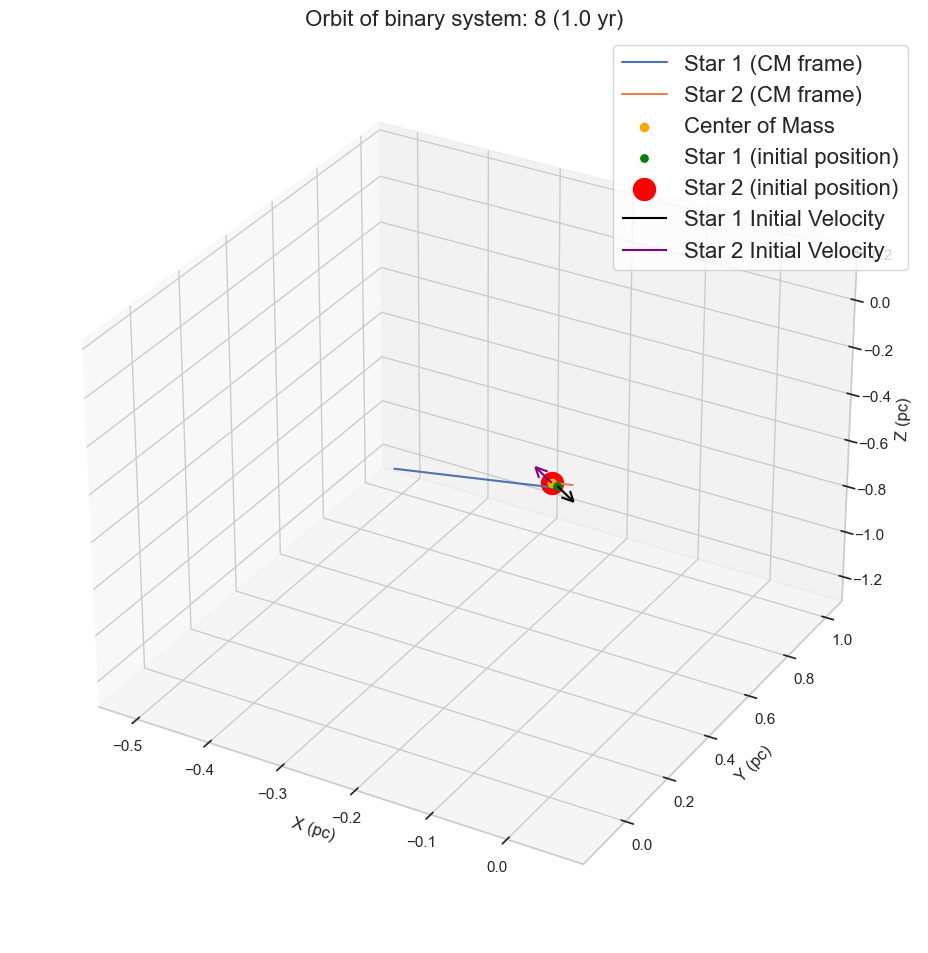

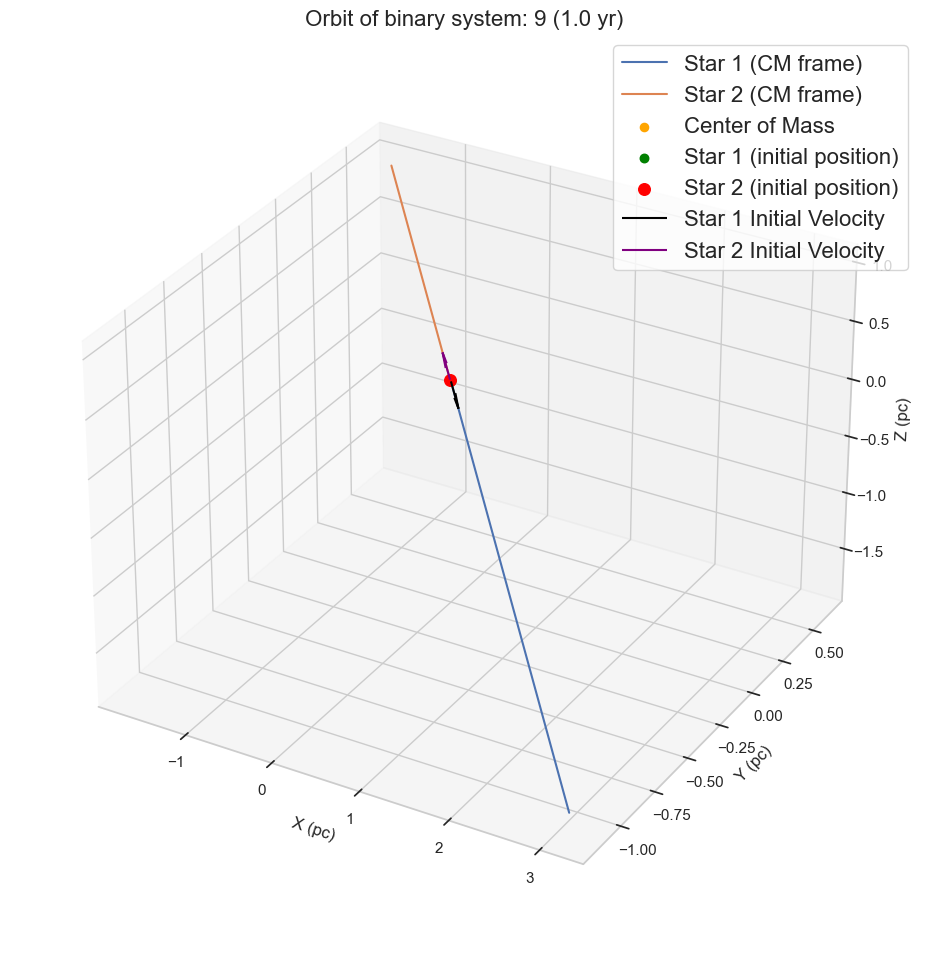

In [10]:
from scipy.integrate import solve_ivp
from astropy.coordinates import SkyCoord


# Constants
G_kms_pc_Msun = 4.302e-3  # pc * (km/s)^2 / Msun

def astro_to_cartesian(star1, star2):
    # Average parallax to enforce consistent distance scale
    avg_parallax = (star1['parallax'] + star2['parallax']) / 2  # mas
    distance = (1000 / avg_parallax) * u.pc

    # SkyCoord objects
    c1 = SkyCoord(
        ra=star1['ra'] * u.deg,
        dec=star1['dec'] * u.deg,
        distance=distance,
        #distance = (1000 / star1['parallax']) * u.pc,
        pm_ra_cosdec=star1['pmra'] * u.mas/u.yr,
        pm_dec=star1['pmdec'] * u.mas/u.yr
        #radial_velocity=star1['radial_velocity'] * u.km/u.s
    )

    c2 = SkyCoord(
        ra=star2['ra'] * u.deg,
        dec=star2['dec'] * u.deg,
        distance=distance,
        #distance = (1000 / star2['parallax']) * u.pc,
        pm_ra_cosdec=star2['pmra'] * u.mas/u.yr,
        pm_dec=star2['pmdec'] * u.mas/u.yr
        #radial_velocity=star2['radial_velocity'] * u.km/u.s
    )

    r1 = c1.cartesian.xyz.to(u.pc).value
    v1 = c1.velocity.d_xyz.to(u.km/u.s).value
    r2 = c2.cartesian.xyz.to(u.pc).value
    v2 = c2.velocity.d_xyz.to(u.km/u.s).value

    return r1, v1, r2, v2


# Define acceleration function for the two-body problem
def two_body_dynamics(t, y, G, m1, m2):
    r1 = y[0:3]
    v1 = y[3:6]
    r2 = y[6:9]
    v2 = y[9:12]

    ep = 0.0

    r_rel = r2 - r1
    dist = np.linalg.norm(r_rel)
    acc1 = G * m2 * r_rel / (dist + ep)**3
    acc2 = -G * m1 * r_rel / (dist + ep)**3

    dydt = np.zeros(12)
    dydt[0:3] = v1
    dydt[3:6] = acc1
    dydt[6:9] = v2
    dydt[9:12] = acc2
    return dydt

def get_ax_tick(ax):
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    zticks = ax.get_zticks()

    # median spacing (guards against unequal or reversed ticks)
    dx = np.median(np.diff(np.sort(xticks)))
    dy = np.median(np.diff(np.sort(yticks)))
    dz = np.median(np.diff(np.sort(zticks)))

    # choose the smallest spacing so the arrow fits whichever axis is most crowded
    tick_interval = min(dx, dy, dz)
    return tick_interval


def get_velocity_vector_plot(v1_cm, v2_cm, frac=0.6, tick_interval=0.1):
    ARROW_LEN = tick_interval * frac

    v1_hat = v1_cm / np.linalg.norm(v1_cm)
    v2_hat = v2_cm / np.linalg.norm(v2_cm)

    v1_plot = v1_hat * ARROW_LEN
    v2_plot = v2_hat * ARROW_LEN

    return v1_plot, v2_plot




# Time span for integration (10 days in Myr: 10 / 365.25 / 1e6)
t_max_yr = 1.0  # 3.65 days
t_span = (0, t_max_yr)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

for index, _ in binary1.iterrows():

    # Extract the first binary pair
    star1 = binary1.loc[index]
    star2 = binary2.loc[index]

    # Convert astrometric data to Cartesian coordinates
    r1, v1, r2, v2 = astro_to_cartesian(star1, star2)


    # Masses of the stars in solar masses
    m1 = star1['mass']  # in solar masses
    m2 = star2['mass']  # in solar masses

    M = m1 + m2

    r_cm = (m1 * r1 + m2 * r2) / M
    v_cm = (m1 * v1 + m2 * v2) / M

    r1_cm = r1 - r_cm
    r2_cm = r2 - r_cm
    v1_cm = v1 - v_cm
    v2_cm = v2 - v_cm

    # Initial conditions
    y0 = np.concatenate([r1, v1, r2, v2])


    # Integrate the system
    sol = solve_ivp(two_body_dynamics, t_span, y0, t_eval=t_eval, args=(G_kms_pc_Msun, m1, m2), rtol=1e-10, atol=1e-12)

    # Extract trajectories
    r1_traj = sol.y[0:3]
    r2_traj = sol.y[6:9]

    # moving to their center of mass frame
    r_com_traj = (m1 * r1_traj + m2 * r2_traj) / M

    # Positions relative to center of mass
    r1_com_traj = r1_traj - r_com_traj
    r2_com_traj = r2_traj - r_com_traj


    # Plotting the orbit
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(r1_com_traj[0], r1_com_traj[1], r1_com_traj[2], label='Star 1 (CM frame)')
    ax.plot(r2_com_traj[0], r2_com_traj[1], r2_com_traj[2], label='Star 2 (CM frame)')
    ax.scatter([0], [0], [0], color='orange', s=35, label='Center of Mass')
    ax.scatter(r1_com_traj[0, 0], r1_com_traj[1, 0], r1_com_traj[2, 0], color='green', s=50*m1, label='Star 1 (initial position)')
    ax.scatter(r2_com_traj[0, 0], r2_com_traj[1, 0], r2_com_traj[2, 0], color='red', s=50*m2, label='Star 2 (initial position)')

    # Plot initial velocity vectors
    tick_interval = get_ax_tick(ax)
    v1_plot, v2_plot = get_velocity_vector_plot(v1_cm, v2_cm, frac=1.0, tick_interval=tick_interval)

    ax.quiver(
        r1_com_traj[0, 0], r1_com_traj[1, 0], r1_com_traj[2, 0],
        v1_plot[0], v1_plot[1], v1_plot[2],
        color='black', linewidth=1.5, arrow_length_ratio=0.5, label='Star 1 Initial Velocity')
    ax.quiver(
        r2_com_traj[0, 0], r2_com_traj[1, 0], r2_com_traj[2, 0],
        v2_plot[0], v2_plot[1], v2_plot[2],
        color='purple', linewidth=1.5, arrow_length_ratio=0.5, label='Star 2 Initial Velocity')
    
    # Set labels and title
    ax.set_xlabel('X (pc)')
    ax.set_ylabel('Y (pc)')
    ax.set_zlabel('Z (pc)')
    ax.set_title(f'Orbit of binary system: {index} ({t_max_yr} yr)', fontsize=16)
    ax.legend(fontsize=16)
    ax.grid(True)
    ax.set_box_aspect(None, zoom=0.95)

    fig.tight_layout(pad=2.0)  # Increase padding
    #fig.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)
    

    if save:
        plt.savefig(plotPath+f'computation_orbital_plot_{index}.png', dpi=300, bbox_inches='tight')
    
    plt.show()